# <center> 1. Feature Analysis (40 points) <center>

<center> I confirm that I have not used any GPT-generated responses for any part of this assignment. <center>

Extract six features from each speech segment:
- The min, max, mean of pitch
- The min, max, mean of intensity

In [28]:
import os
import glob
import numpy as np
import pandas as pd
import parselmouth

DATA_DIR = "hw3_speech_files"   

def parse_metadata(wav_path):
    name = os.path.basename(wav_path).replace(".wav", "")
    parts = name.split("_")
    speaker = parts[0]         
    session = parts[1]         
    emotion = parts[2]          
    return speaker, session, emotion

In [ ]:
def extract_features_for_file(wav_path):
    sound = parselmouth.Sound(wav_path)

    if sound.get_number_of_channels() > 1:
        sound = sound.extract_channel(1)   

    # Pitch 
    pitch = sound.to_pitch(pitch_floor=75,
                           pitch_ceiling=600)
    pitch_values = pitch.selected_array["frequency"]  

    pitch_values = pitch_values[
        np.isfinite(pitch_values) & (pitch_values > 0)
    ]

    if len(pitch_values) == 0:
        min_pitch = max_pitch = mean_pitch = np.nan
    else:
        min_pitch = float(np.min(pitch_values))
        max_pitch = float(np.max(pitch_values))
        mean_pitch = float(np.mean(pitch_values))

    # Intensity 
    intensity = sound.to_intensity(time_step=None, minimum_pitch=75)
    intensity_values = np.squeeze(intensity.values)

    # 0 NaN
    intensity_values = intensity_values[
        np.isfinite(intensity_values) & (intensity_values > 0)
    ]

    if len(intensity_values) == 0:
        min_intensity = max_intensity = mean_intensity = np.nan
    else:
        min_intensity = float(np.min(intensity_values))
        max_intensity = float(np.max(intensity_values))
        mean_intensity = float(np.mean(intensity_values))

    speaker, session, emotion = parse_metadata(wav_path)

    return {
        "file": os.path.basename(wav_path),
        "speaker": speaker,
        "session": session,
        "emotion": emotion,
        "min_pitch": min_pitch,
        "max_pitch": max_pitch,
        "mean_pitch": mean_pitch,
        "min_intensity": min_intensity,
        "max_intensity": max_intensity,
        "mean_intensity": mean_intensity,
    }


In [30]:
wav_paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.wav")))

rows = []
for p in wav_paths:
    rows.append(extract_features_for_file(p))

feat_df = pd.DataFrame(rows)
feat_df.to_csv("parselmouth_features.csv", index=False)
feat_df.head()

,file,speaker,session,emotion,min_pitch,max_pitch,mean_pitch,min_intensity,max_intensity,mean_intensity
0,cc_001_anxiety_910.77_May-twenty-third.wav,cc,001,anxiety,76.851940,134.315515,102.734915,48.573983,80.261238,68.821829
1,cc_001_anxiety_916.11_Eight-hundred-eight.wav,cc,001,anxiety,88.357876,470.846252,141.611068,51.952659,82.362566,68.802924
2,cc_001_anxiety_918.66_Eight-hundred-eight.wav,cc,001,anxiety,77.727072,446.765057,137.602579,44.266131,81.408653,69.223235
3,cc_001_anxiety_928.48_Four-thousand-eight.wav,cc,001,anxiety,93.122852,532.985706,159.949508,49.420874,85.871010,72.128965
4,cc_001_anxiety_934.73_Nine-thousand-six.wav,cc,001,anxiety,81.534891,156.770768,106.813002,44.370192,77.682918,67.401950


In [31]:
# check 
num_speakers = feat_df["speaker"].nunique()
print("Number of speakers:", num_speakers)

print("Speakers:", feat_df["speaker"].unique())

print("\nCounts per speaker:")
print(feat_df["speaker"].value_counts())

Number of speakers: 7
Speakers: ['cc' 'cl' 'gg' 'jg' 'mf' 'mk' 'mm']

Counts per speaker:
speaker
gg    420
mk    397
cl    368
mm    302
mf    299
jg    273
cc    265
Name: count, dtype: int64


## Unnormalized features

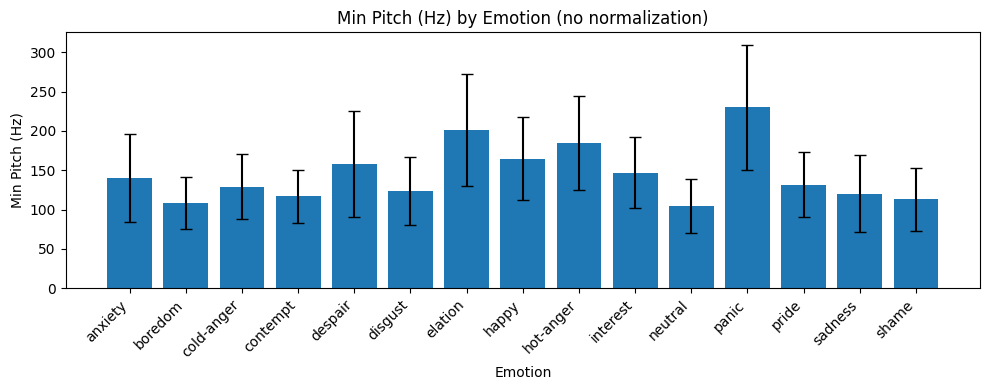

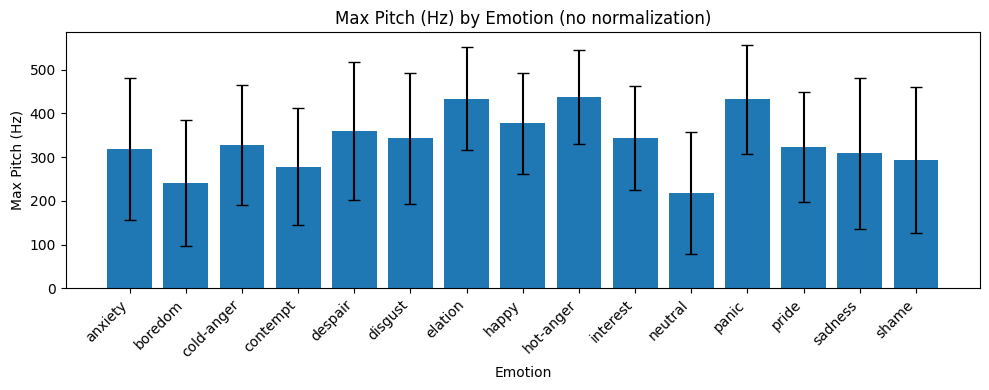

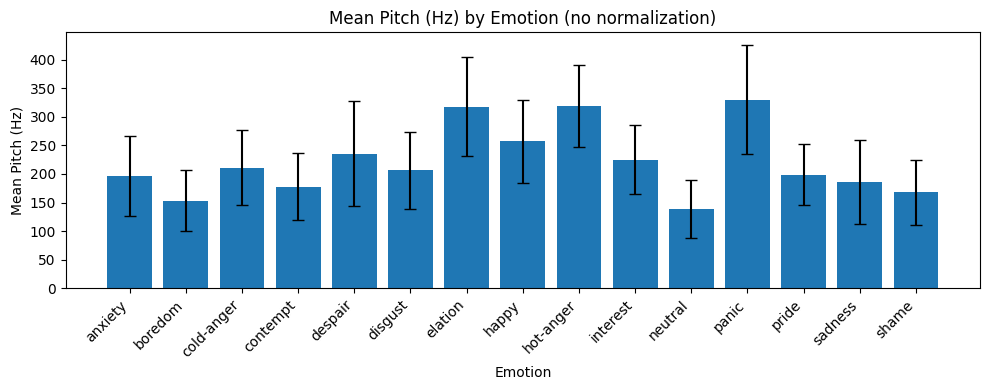

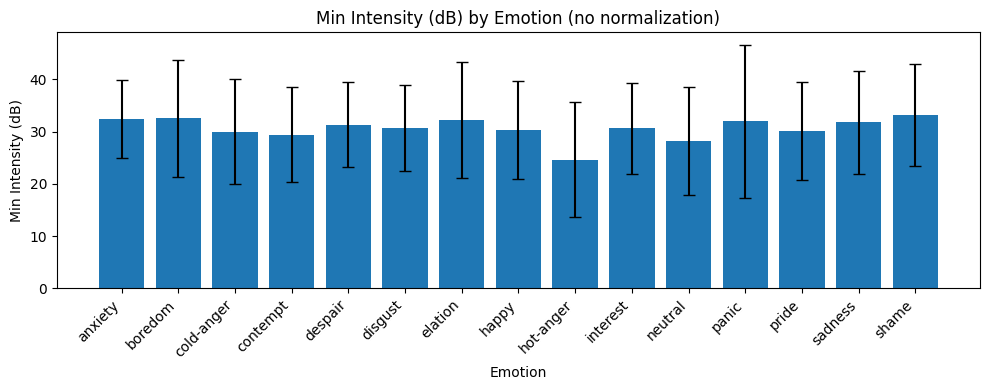

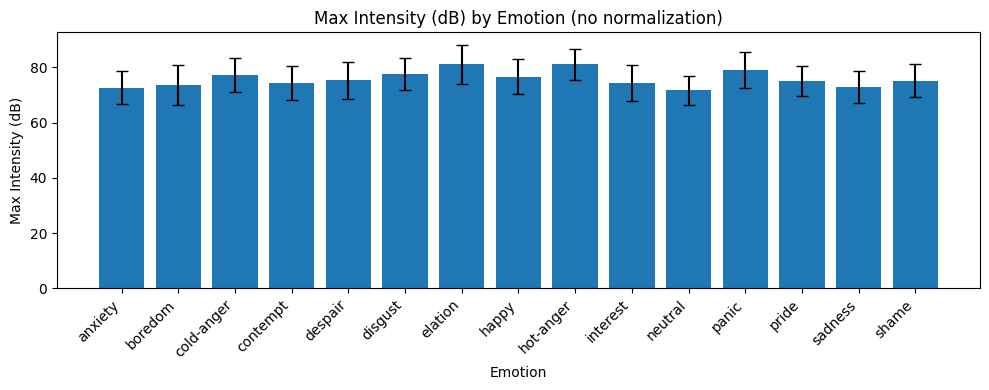

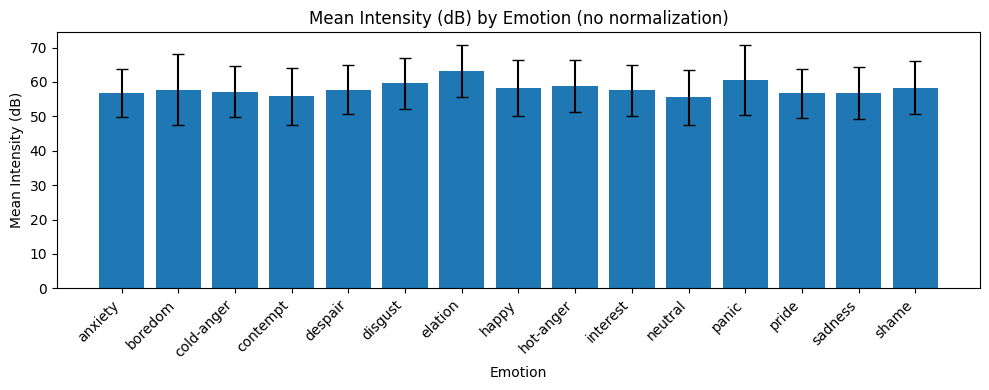

In [32]:
import numpy as np
import matplotlib.pyplot as plt

emotion_order = [
    "anxiety", "boredom", "cold-anger", "contempt", "despair",
    "disgust", "elation", "happy", "hot-anger", "interest",
    "neutral", "panic", "pride", "sadness", "shame"
]

features = [
    "min_pitch", "max_pitch", "mean_pitch",
    "min_intensity", "max_intensity", "mean_intensity"
]

pretty_names = {
    "min_pitch": "Min Pitch (Hz)",
    "max_pitch": "Max Pitch (Hz)",
    "mean_pitch": "Mean Pitch (Hz)",
    "min_intensity": "Min Intensity (dB)",
    "max_intensity": "Max Intensity (dB)",
    "mean_intensity": "Mean Intensity (dB)",
}

for feat in features:
    stats = (
        feat_df
        .groupby("emotion")[feat]
        .agg(["mean", "std"])
        .reindex(emotion_order) 
    )

    x = np.arange(len(stats))

    plt.figure(figsize=(10, 4))

    plt.bar(x, stats["mean"], yerr=stats["std"], capsize=4)
    plt.xticks(x, stats.index, rotation=45, ha="right")
    plt.ylabel(pretty_names[feat])
    plt.xlabel("Emotion")
    plt.title(f"{pretty_names[feat]} by Emotion (no normalization)")
    plt.tight_layout()
    plt.show()

## Normalized features

For the normalized versions of the plots, I applied per-speaker z-score normalization to both pitch and intensity. The goal is to remove speaker-specific differences in overall pitch range and loudness, so that we can better compare how emotions affect relative changes within each speaker.

Concretely, for each speaker we first extracted all frame-level pitch values (75–600 Hz, Praat autocorrelation) and all frame-level intensity values (minimum pitch 75 Hz, automatic time step) from all of their segments. I concatenated these arrays across all utterances of that speaker and computed a single global mean and standard deviation for pitch $(\mu^{\text{pitch}}_s, \sigma^{\text{pitch}}_s)$ and for intensity $(\mu^{\text{int}}_s, \sigma^{\text{int}}_s)$. Then, for every segment from speaker s, I normalized each frame x as

$$z = \frac{x - \mu_s}{\sigma_s}$$

After obtaining the frame-level z-scores, we recomputed the min, max, and mean of pitch and intensity for each segment from the normalized sequences. These six z-scored features (min/max/mean pitch z, min/max/mean intensity z) are used in the “with normalization” plots.

I chose per-speaker z-score normalization because it explicitly controls for large inter-speaker variability in absolute pitch and intensity (e.g., naturally higher voices vs. lower voices), while preserving the within-speaker relative deviations that are more likely to be driven by emotion. This makes the emotion-level comparisons across the corpus more interpretable than using raw Hz/dB values.

In [33]:
from collections import defaultdict

def get_pitch_intensity_arrays(wav_path):
    sound = parselmouth.Sound(wav_path)
    if sound.get_number_of_channels() > 1:
        sound = sound.extract_channel(1)

    pitch = sound.to_pitch(pitch_floor=75, pitch_ceiling=600)
    pitch_values = pitch.selected_array["frequency"]
    pitch_values = pitch_values[np.isfinite(pitch_values) & (pitch_values > 0)]

    intensity = sound.to_intensity(time_step=None, minimum_pitch=75)
    intensity_values = np.squeeze(intensity.values)
    intensity_values = intensity_values[np.isfinite(intensity_values) & (intensity_values > 0)]

    return pitch_values, intensity_values

In [34]:
pitch_by_spk = defaultdict(list)
intensity_by_spk = defaultdict(list)

for p in wav_paths:
    speaker, _, _ = parse_metadata(p)
    pitch_vals, inten_vals = get_pitch_intensity_arrays(p)

    if pitch_vals.size > 0:
        pitch_by_spk[speaker].append(pitch_vals)
    if inten_vals.size > 0:
        intensity_by_spk[speaker].append(inten_vals)

speaker_stats = {}
for spk in pitch_by_spk.keys():
    all_pitch = np.concatenate(pitch_by_spk[spk]) if pitch_by_spk[spk] else np.array([])
    all_inten = np.concatenate(intensity_by_spk[spk]) if intensity_by_spk[spk] else np.array([])

    mu_pitch = float(all_pitch.mean()) if all_pitch.size > 0 else np.nan
    std_pitch = float(all_pitch.std(ddof=0)) if all_pitch.size > 0 else np.nan

    mu_int = float(all_inten.mean()) if all_inten.size > 0 else np.nan
    std_int = float(all_inten.std(ddof=0)) if all_inten.size > 0 else np.nan

    speaker_stats[spk] = {
        "mu_pitch": mu_pitch,
        "std_pitch": std_pitch,
        "mu_int": mu_int,
        "std_int": std_int,
    }

speaker_stats  

{'cc': {'mu_pitch': 178.3511135946801,
  'std_pitch': 91.4355151452941,
  'mu_int': 56.04156692582997,
  'std_int': 15.39017249828006},
 'cl': {'mu_pitch': 148.91988378464137,
  'std_pitch': 85.93694481369417,
  'mu_int': 49.283799911337226,
  'std_int': 19.448201898401702},
 'gg': {'mu_pitch': 253.8356666627775,
  'std_pitch': 100.73677633791709,
  'mu_int': 64.37514100093614,
  'std_int': 12.336461230720955},
 'jg': {'mu_pitch': 267.8520935465844,
  'std_pitch': 102.40130916287134,
  'mu_int': 51.984761715330286,
  'std_int': 13.446184950658788},
 'mf': {'mu_pitch': 191.17937704771802,
  'std_pitch': 85.33275915013397,
  'mu_int': 63.5656500928419,
  'std_int': 12.606191170048138},
 'mk': {'mu_pitch': 294.1211816268872,
  'std_pitch': 101.21924920847992,
  'mu_int': 57.43274558196108,
  'std_int': 13.965758326640856},
 'mm': {'mu_pitch': 219.10670758930337,
  'std_pitch': 96.2584082794782,
  'mu_int': 59.71102240935385,
  'std_int': 13.643744911126227}}

In [ ]:
def extract_normalized_features_for_file(wav_path, speaker_stats):
    pitch_vals, inten_vals = get_pitch_intensity_arrays(wav_path)
    speaker, session, emotion = parse_metadata(wav_path)
    stats = speaker_stats[speaker]

    # pitch z-score
    if pitch_vals.size > 0 and np.isfinite(stats["std_pitch"]) and stats["std_pitch"] > 0:
        pitch_z = (pitch_vals - stats["mu_pitch"]) / stats["std_pitch"]
    else:
        pitch_z = np.array([])

    if pitch_z.size == 0:
        min_pitch_z = max_pitch_z = mean_pitch_z = np.nan
    else:
        min_pitch_z = float(pitch_z.min())
        max_pitch_z = float(pitch_z.max())
        mean_pitch_z = float(pitch_z.mean())

    # intensity z-score 
    if inten_vals.size > 0 and np.isfinite(stats["std_int"]) and stats["std_int"] > 0:
        inten_z = (inten_vals - stats["mu_int"]) / stats["std_int"]
    else:
        inten_z = np.array([])

    if inten_z.size == 0:
        min_int_z = max_int_z = mean_int_z = np.nan
    else:
        min_int_z = float(inten_z.min())
        max_int_z = float(inten_z.max())
        mean_int_z = float(inten_z.mean())

    return {
        "file": os.path.basename(wav_path),
        "speaker": speaker,
        "session": session,
        "emotion": emotion,
        "min_pitch_z": min_pitch_z,
        "max_pitch_z": max_pitch_z,
        "mean_pitch_z": mean_pitch_z,
        "min_intensity_z": min_int_z,
        "max_intensity_z": max_int_z,
        "mean_intensity_z": mean_int_z,
    }


In [36]:
rows_norm = [extract_normalized_features_for_file(p, speaker_stats) for p in wav_paths]
norm_feat_df = pd.DataFrame(rows_norm)
norm_feat_df.to_csv("parselmouth_normalized_features.csv", index=False)
norm_feat_df.head()

,file,speaker,session,emotion,min_pitch_z,max_pitch_z,mean_pitch_z,min_intensity_z,max_intensity_z,mean_intensity_z
0,cc_001_anxiety_910.77_May-twenty-third.wav,cc,001,anxiety,-1.110063,-0.481603,-0.826989,-0.485218,1.573710,0.830417
1,cc_001_anxiety_916.11_Eight-hundred-eight.wav,cc,001,anxiety,-0.984226,3.198923,-0.401814,-0.265683,1.710247,0.829189
2,cc_001_anxiety_918.66_Eight-hundred-eight.wav,cc,001,anxiety,-1.100492,2.935555,-0.445653,-0.765127,1.648265,0.856499
3,cc_001_anxiety_928.48_Four-thousand-eight.wav,cc,001,anxiety,-0.932113,3.878521,-0.201252,-0.430190,1.938214,1.045303
4,cc_001_anxiety_934.73_Nine-thousand-six.wav,cc,001,anxiety,-1.058847,-0.236017,-0.782389,-0.758365,1.406180,0.738158


In [37]:
for col in [
    "min_pitch_z", "max_pitch_z", "mean_pitch_z",
    "min_intensity_z", "max_intensity_z", "mean_intensity_z",
]:
    feat_df[col] = norm_feat_df[col]

feat_df.head() 

,file,speaker,session,emotion,min_pitch,max_pitch,mean_pitch,min_intensity,max_intensity,mean_intensity,min_pitch_z,max_pitch_z,mean_pitch_z,min_intensity_z,max_intensity_z,mean_intensity_z
0,cc_001_anxiety_910.77_May-twenty-third.wav,cc,001,anxiety,76.851940,134.315515,102.734915,48.573983,80.261238,68.821829,-1.110063,-0.481603,-0.826989,-0.485218,1.573710,0.830417
1,cc_001_anxiety_916.11_Eight-hundred-eight.wav,cc,001,anxiety,88.357876,470.846252,141.611068,51.952659,82.362566,68.802924,-0.984226,3.198923,-0.401814,-0.265683,1.710247,0.829189
2,cc_001_anxiety_918.66_Eight-hundred-eight.wav,cc,001,anxiety,77.727072,446.765057,137.602579,44.266131,81.408653,69.223235,-1.100492,2.935555,-0.445653,-0.765127,1.648265,0.856499
3,cc_001_anxiety_928.48_Four-thousand-eight.wav,cc,001,anxiety,93.122852,532.985706,159.949508,49.420874,85.871010,72.128965,-0.932113,3.878521,-0.201252,-0.430190,1.938214,1.045303
4,cc_001_anxiety_934.73_Nine-thousand-six.wav,cc,001,anxiety,81.534891,156.770768,106.813002,44.370192,77.682918,67.401950,-1.058847,-0.236017,-0.782389,-0.758365,1.406180,0.738158


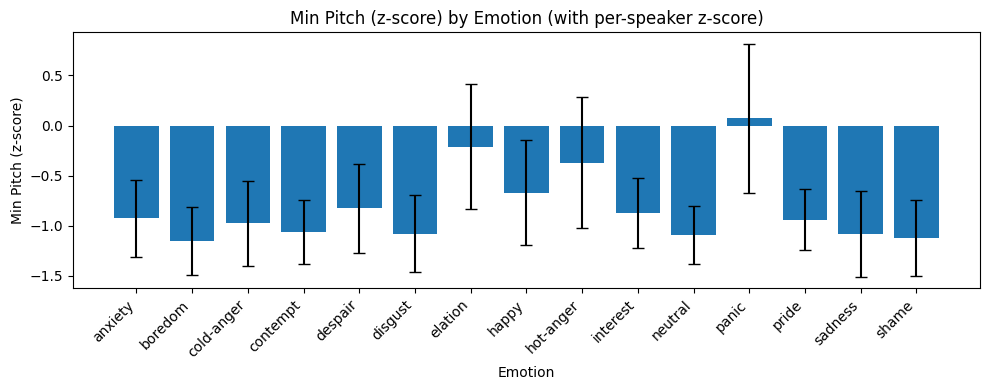

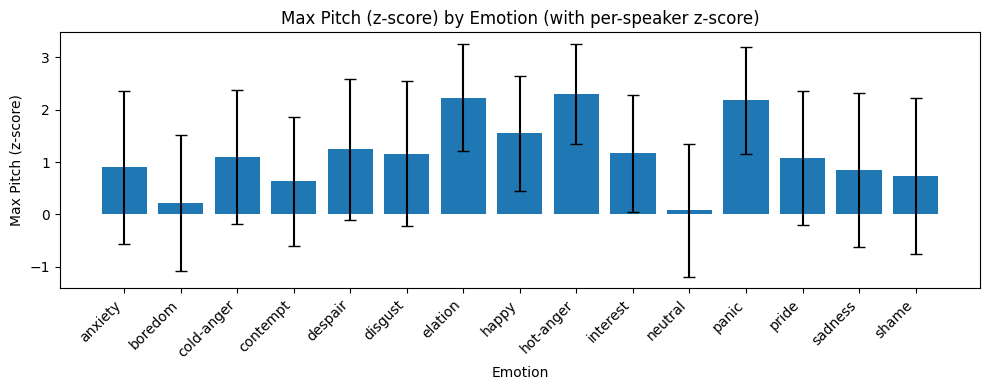

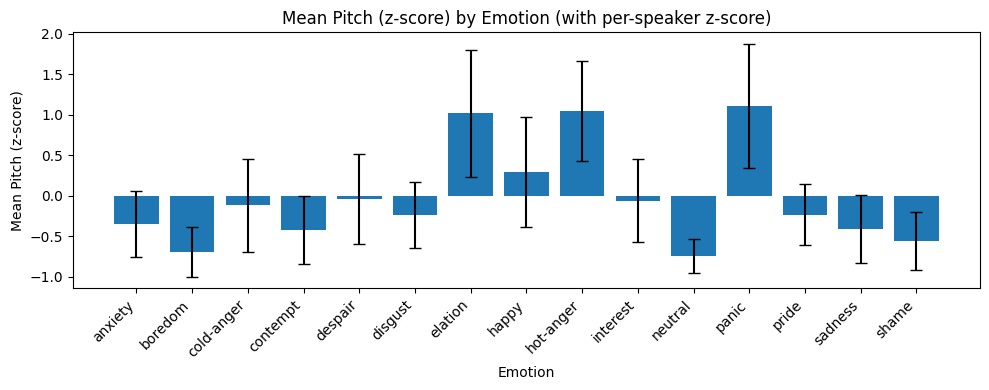

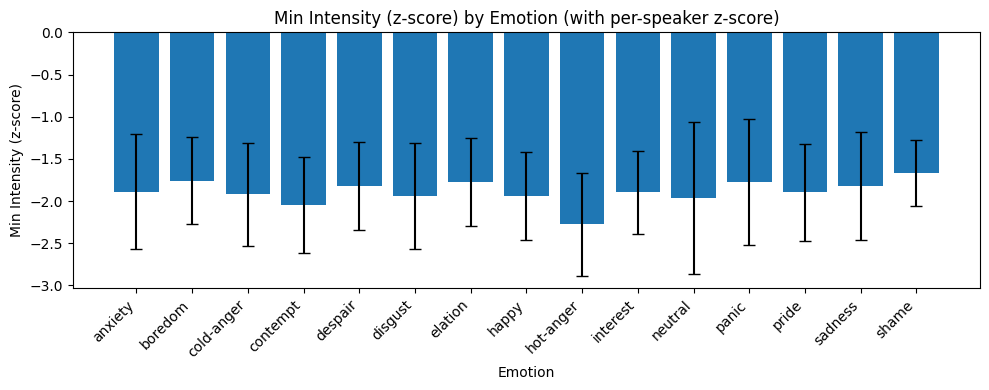

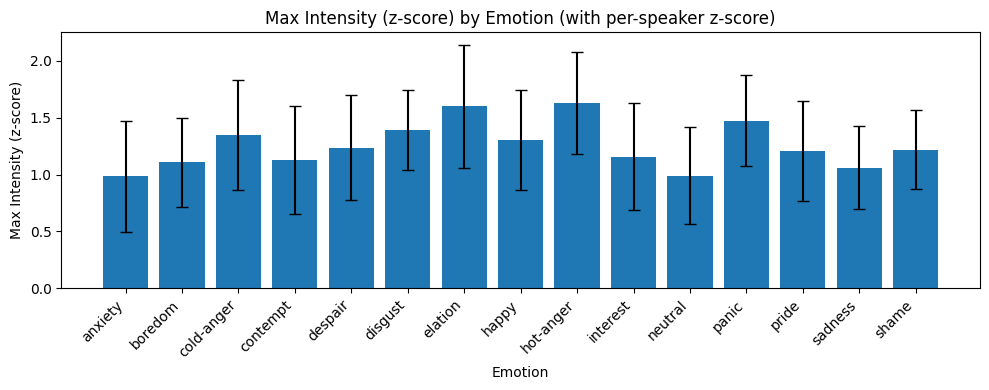

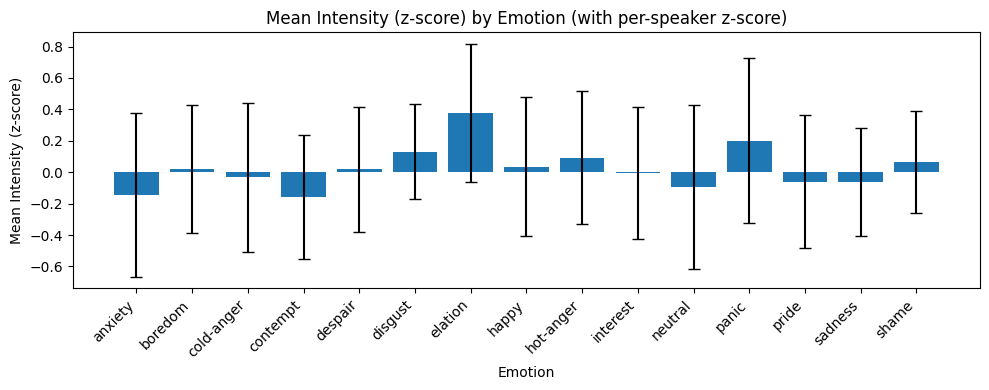

In [38]:
emotion_order = [
    "anxiety", "boredom", "cold-anger", "contempt", "despair",
    "disgust", "elation", "happy", "hot-anger", "interest",
    "neutral", "panic", "pride", "sadness", "shame"
]

features_z = [
    "min_pitch_z", "max_pitch_z", "mean_pitch_z",
    "min_intensity_z", "max_intensity_z", "mean_intensity_z",
]

pretty_names_z = {
    "min_pitch_z": "Min Pitch (z-score)",
    "max_pitch_z": "Max Pitch (z-score)",
    "mean_pitch_z": "Mean Pitch (z-score)",
    "min_intensity_z": "Min Intensity (z-score)",
    "max_intensity_z": "Max Intensity (z-score)",
    "mean_intensity_z": "Mean Intensity (z-score)",
}

for feat in features_z:
    stats = (
        feat_df
        .groupby("emotion")[feat]
        .agg(["mean", "std"])
        .reindex(emotion_order)
    )

    x = np.arange(len(stats))

    plt.figure(figsize=(10, 4))
    plt.bar(x, stats["mean"], yerr=stats["std"], capsize=4)
    plt.xticks(x, stats.index, rotation=45, ha="right")
    plt.ylabel(pretty_names_z[feat])
    plt.xlabel("Emotion")
    plt.title(f"{pretty_names_z[feat]} by Emotion (with per-speaker z-score)")
    plt.tight_layout()
    plt.show()

## Report

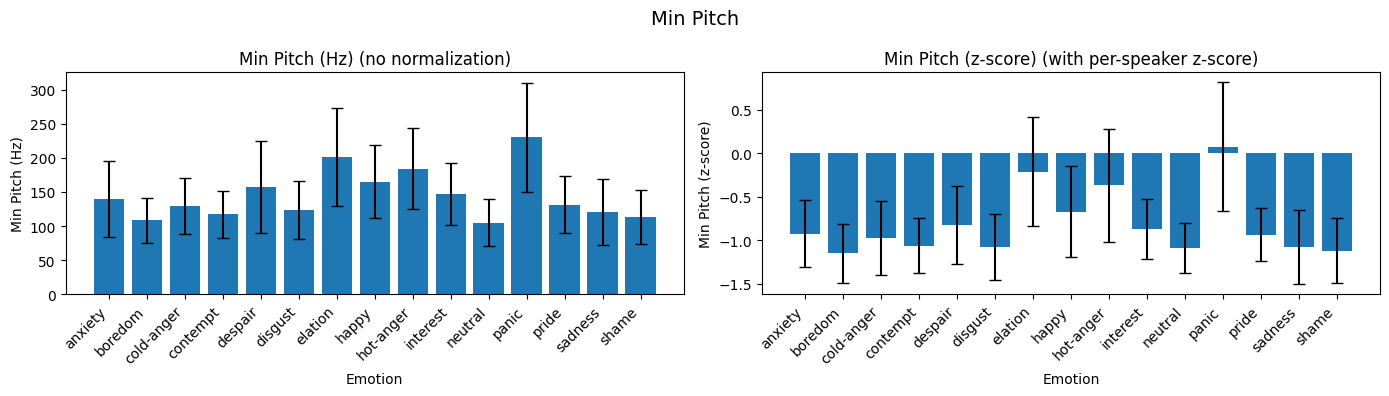

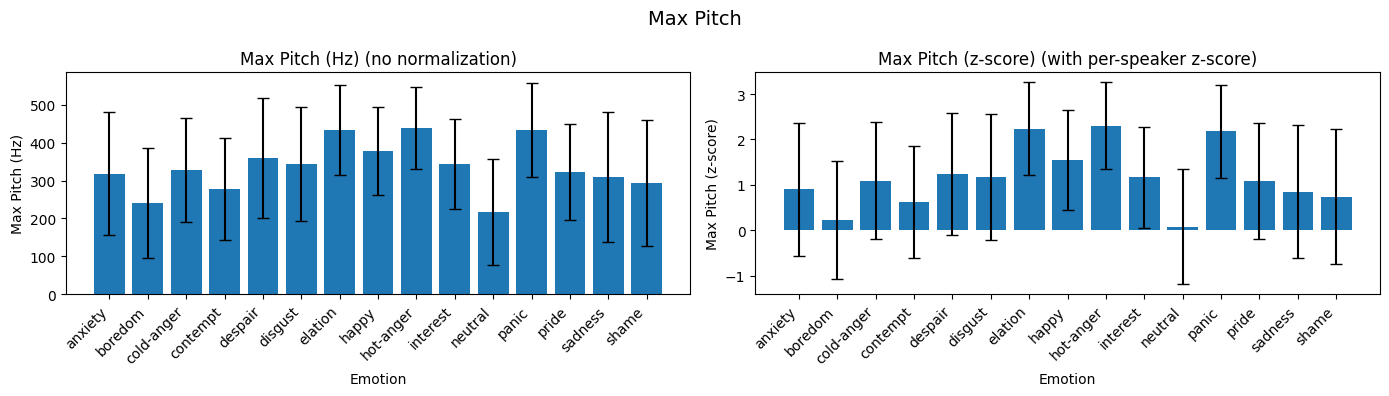

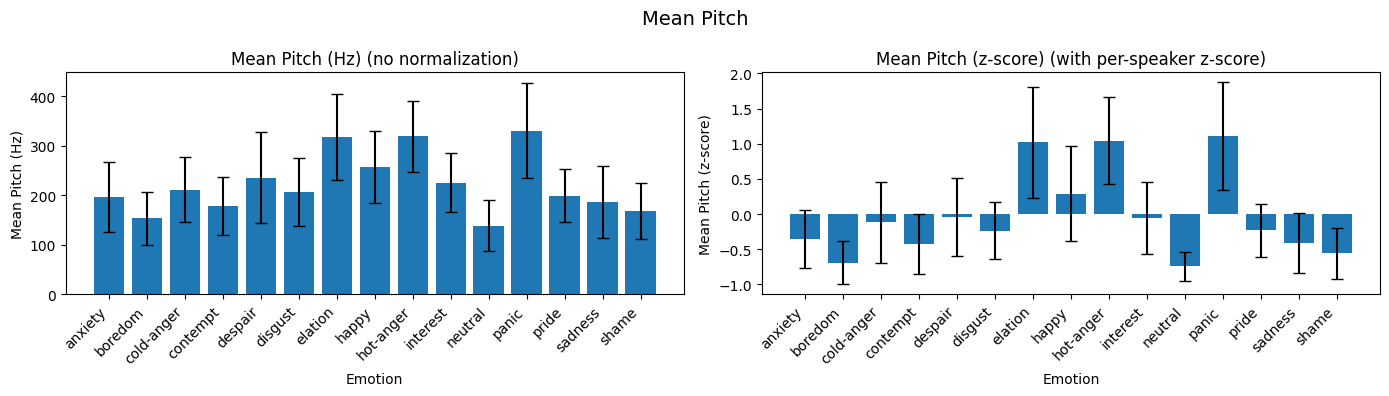

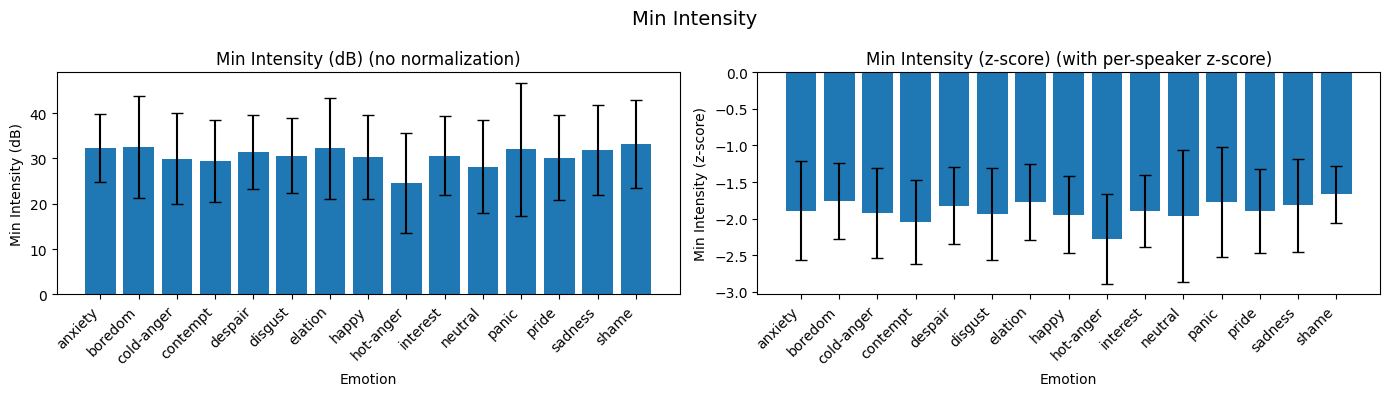

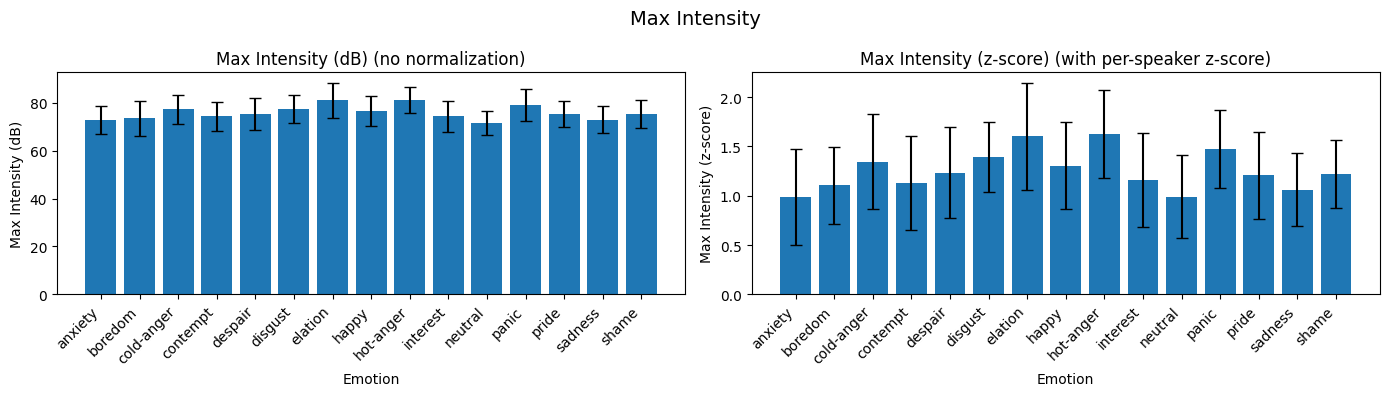

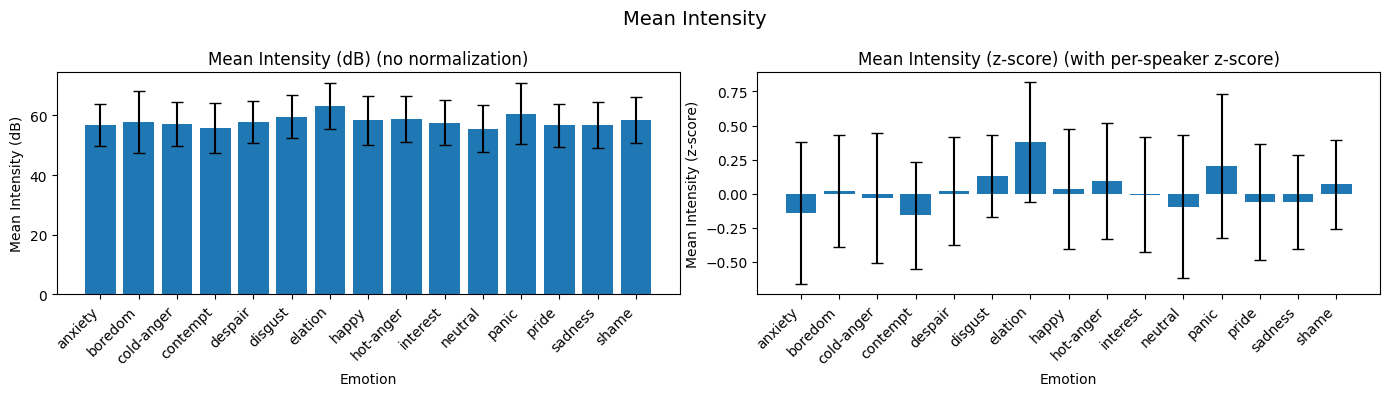

In [39]:
feature_pairs = [
    ("min_pitch", "min_pitch_z"),
    ("max_pitch", "max_pitch_z"),
    ("mean_pitch", "mean_pitch_z"),
    ("min_intensity", "min_intensity_z"),
    ("max_intensity", "max_intensity_z"),
    ("mean_intensity", "mean_intensity_z"),
]

for feat_raw, feat_z in feature_pairs:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True)
    x = np.arange(len(emotion_order))

    # no norm
    stats_raw = (
        feat_df
        .groupby("emotion")[feat_raw]
        .agg(["mean", "std"])
        .reindex(emotion_order)
    )
    axes[0].bar(x, stats_raw["mean"], yerr=stats_raw["std"], capsize=4)
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(emotion_order, rotation=45, ha="right")
    axes[0].set_ylabel(pretty_names[feat_raw])
    axes[0].set_xlabel("Emotion")
    axes[0].set_title(f"{pretty_names[feat_raw]} (no normalization)")

    # per-speaker z-score 
    stats_z = (
        feat_df
        .groupby("emotion")[feat_z]
        .agg(["mean", "std"])
        .reindex(emotion_order)
    )
    axes[1].bar(x, stats_z["mean"], yerr=stats_z["std"], capsize=4)
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(emotion_order, rotation=45, ha="right")
    axes[1].set_ylabel(pretty_names_z[feat_z])
    axes[1].set_xlabel("Emotion")
    axes[1].set_title(f"{pretty_names_z[feat_z]} (with per-speaker z-score)")

    fig.suptitle(pretty_names[feat_raw].split("(")[0].strip(), fontsize=14)
    fig.tight_layout()
    plt.show()

From the 12 plots (raw and normalized features):

1.	High-arousal emotions systematically raise pitch, especially for panic.

    In the raw plots of min/max/mean pitch, panic consistently has the highest values, with elation, happy, and hot-anger also clearly above most other emotions. After per-speaker z-score normalization, these emotions still have positive or near-zero pitch z-scores, while low-arousal emotions remain negative. This suggests that even after controlling for each speaker’s baseline, high-arousal states are produced with systematically higher pitch.

2.	Low-arousal and negative emotions show lower pitch relative to each speaker’s baseline.
        
    Emotions such as boredom, sadness, shame, and neutral tend to have lower min/max/mean pitch in the raw plots. In the normalized plots, their pitch z-scores are mostly negative, often among the lowest across all classes. I interpret this as evidence that speakers not only sound lower in absolute Hz, but also shift their pitch down relative to their own typical range when expressing these low-arousal or subdued emotions.

3.	High-arousal emotions are also louder, especially in terms of maximum and mean intensity.

    In the raw max and mean intensity plots, elation, happy, hot-anger, panic, and pride are clustered at the higher end of the dB scale, whereas boredom, sadness, and neutral tend to be softer. After normalization, these high-arousal emotions generally have positive intensity z-scores, while low-arousal emotions are closer to zero or negative. This pattern suggests a consistent coupling between emotional arousal and vocal loudness, not just pitch.

4.	Panic and elation show large variability across speakers, while neutral and boredom are more stable.

    The error bars for panic and elation are relatively large in many of the pitch and intensity plots, both before and after normalization. I take this to mean that speakers use a wider range of acoustic strategies to express these emotions (some sounding extremely high-pitched or loud, others less so). In contrast, neutral and boredom usually have smaller error bars, which suggests that these states are expressed in a more consistent and constrained acoustic space.

5.	Normalization removes strong speaker effects but preserves the relative ordering of emotions.

    In the raw pitch plots, the absolute differences between emotions are very large (on the order of 100–200 Hz), and these differences can easily be influenced by which speakers contribute more samples to a given emotion. After per-speaker z-score normalization, all emotions are centered around the zero baseline, and the dynamic range is compressed, but the ranking across emotions is largely preserved ( panic and elation still high, boredom and sadness still low). I learn from this that a substantial part of the raw variation is due to speaker-specific baselines, and that z-score normalization helps me focus on emotion-driven deviations from each speaker’s typical voice.

6. Normalization sharpens intensity-based differences that looked small in raw dB.

    In the raw max/mean intensity plots, most emotions cluster in a narrow range around ~70–80 dB, so the differences are not visually striking. After per-speaker z-score normalization, I see a much clearer separation: elation, happy, hot-anger, panic, and partly pride shift to positive intensity z-scores, while boredom, sadness, and neutral move to negative values. This tells me that absolute dB values are heavily influenced by microphone and speaker loudness, and normalization is crucial to reveal emotion-driven loudness patterns.

7. Some emotions look strong in raw dB but are “normal” after normalization.

    For example, pride has relatively high raw max/mean intensity, but in the intensity z-score plots it is much closer to zero than elation or panic. This suggests that the speakers who produce pride already tend to speak loudly in general, so pride is not as strong a within-speaker loudness increase as elation or panic. Normalization helps me distinguish this emotion uses loud speakers from this emotion actually makes individual speakers louder than usual.